# The first step is preprocessing. We use the [SSBD Dataset](https://rolandgoecke.net/research/datasets/ssbd/) in order to get the data for hand flapping and spinning. 

## The dataset does contain 75 URLs (although we'll ignore all headbanging videos) to youtube videos. All the data is nicely stored in XML files that I will read to get the youtube videos and also the time stamps of when the behavior (hand flapping or spinning) occurs. Then I will use pytube to download the youtube videos to .mp4 and moviepy to cut the .mp4 videos into the areas of interest. Finally, because some of those areas of interest clips are more than a few seconds long (which is all you need to detect spinning or headbanging) I will take those areas that are > 8 seconds and split them into many clips (that way we have more data.) Also in sections of the video where no behavior is used I will take them as videos as control data. 

In [ ]:
# first change the directory over to ssbd release
import os 
import xml.etree.ElementTree as ET

In [ ]:
# next step would be to get the hand flapping and spinning data 

tree = ET.parse("ssbd-release/Annotations/v_ArmFlapping_07.xml")
root = tree.getroot()
for child in root:
    # for each child in the root 
    if child.tag == "url":
        print(child.text)
    if child.tag == "behaviours":
        for behavior in child: # go through each reported behavior 
            for tag in behavior: # tag is just the attribute of the behavior 
                if tag.tag == "time":
                    print(tag.text)
                if tag.tag == "intensity":
                    print(tag.text)
                if tag.tag == "category":
                    print(tag.text)

In [ ]:
def convert_to_second(time : str) -> int:
    # this will take in a time like "0125" or 1:25 and make it 85 (60 + 25)
    overall_seconds = 0 
    for i, time_char in enumerate(reversed(time)):
        if i == 0:
            overall_seconds += int(time_char)
        if i == 1:
            overall_seconds += int(time_char) * 10
        if i == 2:
            overall_seconds += int(time_char) * 60 
        if i == 3:
            overall_seconds += int(time_char) * 600 
    return overall_seconds 

assert convert_to_second('2345') == 23 * 60 + 45  

def consecutive(data, stepsize=1):
    '''groups up elements in an array that are continous with each other (useful to create sections where none 
    of the behaviors are shown.)'''
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [ ]:
from collections import defaultdict
import math 
import numpy as np

NUM_SECONDS_TO_RECOGNIZE = 8 # hypothesis: takes this many seconds seconds to recognize handflapping + spinning 

URLS_TO_DOWNLOAD = set() # contains all youtube videos to download 
links_to_times = {} # data will be stored here like {link : {'category' : [(start, end)], 'another cat' : [(start, end)]}


for i, file_name in enumerate(os.listdir('ssbd-release/Annotations/')):
    # parse this file 
    tree = ET.parse('ssbd-release/Annotations/' + file_name)
    root = tree.getroot() 
    
    # everything we need to store
    URL = ""
    
    for child in root:
        
        if child.tag == "url":
            URL = child.text # store URL
            URLS_TO_DOWNLOAD.add(URL)
            links_to_times[URL] = defaultdict(list) 
        
        if child.tag == "duration":
            duration = int(child.text[:-1])
            all_times = list(range(duration))
        
        if child.tag == "behaviours": # this child has the list of behaviors 
            for reported_behavior in child: 
                for info in reported_behavior:
                    # gather the start time, end time, and category for this youtube link 
                    if info.tag == "time":
                        # the time will be start:end 
                        times = str(info.text) # contains the string 
                        if times.count(":"): 
                            divider_index = times.index(":")
                        elif times.count("-"):
                            divider_index = times.index("-")
                        else:
                            break # invalid then 
                        actual_start_time, actual_end_time = convert_to_second(times[:divider_index]), convert_to_second(times[divider_index + 1:])
                        START_TIMES, END_TIMES = [], []
                        times = np.array(range(actual_start_time, actual_end_time +1))
                        for time in times:
                            try:
                                all_times.remove(time)
                            except Exception as e:
                                pass 
                        split_times = np.array_split(times, math.ceil(times.shape[0] / NUM_SECONDS_TO_RECOGNIZE))
                        for time in split_times:
                            START_TIMES.append(time[0])
                            END_TIMES.append(time[-1])
                    if info.tag == "category":
                        # this is the label 
                        LABEL = info.text 
                
                # create an entry for this reported behavior 
                for START_TIME, END_TIME in zip(START_TIMES, END_TIMES):
                    links_to_times[URL][LABEL].append((START_TIME, END_TIME))
                    
            idle_times = consecutive(np.array(all_times))
            num_contributed = 0 # each video can only give 4 control clips (because otherwise it takes WAY too long)
            for control_times in idle_times:
                if num_contributed >= 4: 
                    break 
                # times maybe > NUM_SECONDS_TO_RECOGNIZE so split if that is the case 
                if len(control_times) <= NUM_SECONDS_TO_RECOGNIZE:
                    START_TIME, END_TIME = control_times[0], control_times[-1]
                    links_to_times[URL]['control'].append((START_TIME, END_TIME))
                    num_contributed += 1
                else:
                    # needs to be split 
                    control_times_split = np.array_split(control_times, math.ceil(len(control_times) / NUM_SECONDS_TO_RECOGNIZE))
                    for control_time in control_times_split:  
                        START_TIME, END_TIME = control_time[0], control_time[-1]
                        links_to_times[URL]['control'].append((START_TIME, END_TIME))
                        num_contributed += 1
                        if num_contributed >= 4: 
                            break 

In [ ]:
links_to_times

In [ ]:
# pickle this just incase 
import pickle 
with open("links_to_times.pkl", 'wb') as f:
    pickle.dump(links_to_times, f)

In [ ]:
import cv2
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
import pytube
FPS = 30 
i = 0 
for vid, (url, category_times) in enumerate((links_to_times.items())): 
    print(f"staring the {vid+1}th file")
    # download the video 
    print(url)
    try: 
        print("This is url: ", url)
        y = pytube.YouTube(url)
        video = y.streams.get_highest_resolution()
        video.download()
    except Exception as e:
        print(f"annoying url: {url}")
        print(e)
        continue 
        
    for category, times in category_times.items(): 
        folder_path = "behavior_data/" + category + "/"
        
        for start_time, end_time in times:
            try:
                input_file = y.streams.get_highest_resolution().default_filename
                output_file = folder_path + f"{i}.mp4"
                print(os.listdir(folder_path))
                if f"{i}.mp4" not in os.listdir(folder_path):
                    print("adding file")
                    with VideoFileClip(input_file) as video:
                        new = video.subclip(start_time, end_time)
                        new.write_videofile(output_file, audio_codec='aac')
                        i += 1 
            except Exception as e:
                print(f"failed on {i}")
                i += 1 
    os.remove(y.streams.get_highest_resolution().default_filename)

# Directory Structure  

## We have one folder inside of this AnishMachineLearning folder called "behavior_data" that has the "armflapping" and "spinning" folders. There all of the sliced .mp4 files with the behavior of interest are located. 

### We will process headbanging videos even if we are not going to use it because we still want it as a negative case for training the arm flapping & spinning. 

In [ ]:
# for spinning it is just the hand positions that matter right?

import cv2
import mediapipe as mp 
import numpy as np
mp_hands = mp.solutions.hands


cap = cv2.VideoCapture("/Users/anish/Documents/Machine Learning Env/AnishMachineLearning/behavior_data/spinning/37.mp4")
#cap = cv2.VideoCapture(0)
# Initiate holistic model

#capcv2.VideoCapture(0)

hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

while cap.isOpened():
    ret, image = cap.read() 
    if not ret:break 

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = hands.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    height, width, _ = image.shape

    white_image = np.zeros_like(image)
    white_image.fill(255.0)
    
    #check for hand results 
    if results.multi_hand_landmarks:
        for hand_landmark in results.multi_hand_landmarks:
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                x = int(landmark.x * width)
                y = int(landmark.y * height)
                cv2.circle(white_image, (x, y), 5, (100, 100, 0), -1)

    cv2.imshow("", white_image)

    if cv2.waitKey(1) == ord("q"):
        break 

cap.release() 
cv2.destroyAllWindows()

In [ ]:
list(range(21))

# We can try using the y values for each of the hand flapping videos and graph them to see if there is a noticeable difference of the y-values (we'll use the mean of all y-values for all 21 hand landmarks and then graph them).

In [ ]:
import matplotlib.pyplot as plt
import os , cv2
import mediapipe as mp

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/armflapping"):
    video = "behavior_data/armflapping/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

In [ ]:
# now for spinning 

import matplotlib.pyplot as plt
import os 

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/spinning"):
    video = "behavior_data/spinning/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

In [ ]:
# next for headbanging 

# now for spinning 

import matplotlib.pyplot as plt
import os 

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/headbanging"):
    video = "behavior_data/headbanging/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

# First let's get the frames for every arm flapping and control video. If the number of frames is less than 100 frames we will not take it. 

In [2]:
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1; 
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [118]:
import os, cv2
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []

NUM_KEEP = 100

for video_name in tqdm(os.listdir('behavior_data/armflapping')): 
    cap = cv2.VideoCapture('behavior_data/armflapping/' + video_name)  
    FRAMES = [] # frames for this video 
    while True: 
        _, image = cap.read() 
        if not _ : break 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        locs = hand_locations(image) 

        FRAMES.append(locs)
    if len(FRAMES) >= NUM_KEEP and np.sum(np.array(FRAMES)) > 0: 
        # ignore any .DS_Store files
        ARMFLAPPING_VIDEOS.append(np.array(FRAMES))
    
ARMFLAPPING_LABELS = np.ones(len(ARMFLAPPING_VIDEOS))

for video_name in tqdm(os.listdir('behavior_data/control')): 
    cap = cv2.VideoCapture('behavior_data/control/' + video_name)  
    FRAMES = [] # frames for this video 
    while True: 
        _, image = cap.read() 
        if not _ : break 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        locs = hand_locations(image)
                    
        FRAMES.append(locs)
        
    if len(FRAMES) >= NUM_KEEP and np.sum(np.array(FRAMES)) > 0: 
        CONTROL_VIDEOS.append(np.array(FRAMES))
    

CONTROL_LABELS = np.zeros(len(CONTROL_VIDEOS))

100%|██████████| 74/74 [04:22<00:00,  3.55s/it]


In [40]:
#### shuffle and then balance the amount of videos
print(len(CONTROL_VIDEOS), len(ARMFLAPPING_VIDEOS))
amount_of_videos = min([len(CONTROL_VIDEOS), len(ARMFLAPPING_VIDEOS)])

ARMFLAPPING_VIDEOS = np.array(ARMFLAPPING_VIDEOS, dtype = "object")
CONTROL_VIDEOS = np.array(CONTROL_VIDEOS, dtype = "object")
import numpy as np
control_permutation = np.random.permutation(CONTROL_LABELS.shape[0])
CONTROL_VIDEOS, CONTROL_LABELS = CONTROL_VIDEOS[control_permutation], CONTROL_LABELS[control_permutation]

armflapping_permutation = np.random.permutation(ARMFLAPPING_LABELS.shape[0])
ARMFLAPPING_VIDEOS, ARMFLAPPING_LABELS = ARMFLAPPING_VIDEOS[armflapping_permutation], ARMFLAPPING_LABELS[armflapping_permutation]

ARMFLAPPING_VIDEOS, ARMFLAPPING_LABELS = ARMFLAPPING_VIDEOS[:amount_of_videos], ARMFLAPPING_LABELS[:amount_of_videos]
CONTROL_VIDEOS, CONTROL_LABELS = CONTROL_VIDEOS[:amount_of_videos], CONTROL_LABELS[:amount_of_videos]

42 60


In [41]:
assert len(ARMFLAPPING_VIDEOS) == len(CONTROL_VIDEOS)

In [42]:
selected_armflapping_frames = [] # the dimensions of this will be (BS, 100, 84) 
selected_control_frames = [] 

for FRAMES in ARMFLAPPING_VIDEOS: 
    selected_armflapping_frames.append(FRAMES[:NUM_KEEP])

for FRAMES in CONTROL_VIDEOS: 
    selected_control_frames.append(FRAMES[:NUM_KEEP])

In [43]:
ARMFLAPPING_LOCATIONS = np.array(selected_armflapping_frames)
CONTROL_LOCATIONS = np.array(selected_control_frames)

In [44]:
# save these in a pickle file

import pickle 
with open("armflapping_locations.pickle", 'wb') as f: 
    pickle.dump(ARMFLAPPING_LOCATIONS, f)

with open('control_locations.pickle', 'wb') as f: 
    pickle.dump(CONTROL_LOCATIONS, f)

In [45]:
# load them back in 

"""
Armflapping locations.pickle will store the locations of the old, non preprocessed dataset. 
"""

import numpy as np
from numpy import ndarray 
import pickle 

with open("armflapping_locations.pickle", 'rb') as f: 
    ARMFLAPPING_LOCATIONS = pickle.load(f)

with open('control_locations.pickle', 'rb') as f: 
    CONTROL_LOCATIONS = pickle.load(f)

# Now that we have the data for both classes, we'll concatenate it and start training (first with no augmentations.) 

In [46]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS, random_state = 42): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = random_state)
    
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS)

In [121]:
# start training with a vanilla LSTM. 
import tensorflow as tf
tf.config.run_functions_eagerly(True)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences = True), 
    tf.keras.layers.LSTM(128, return_sequences = False), 
    tf.keras.layers.Dense(128, activation = "relu"), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [122]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))

step - loss: 0.3271 - accuracy: 0.8571 - precision_12: 0.8485 - recall_12: 0.8750 - val_loss: 0.3619 - val_accuracy: 0.8571 - val_precision_12: 0.8182 - val_recall_12: 0.9000
Epoch 17/100
2/2 [==============================] - 1s 437ms/step - loss: 0.2841 - accuracy: 0.9048 - precision_12: 0.9333 - recall_12: 0.8750 - val_loss: 0.3461 - val_accuracy: 0.8571 - val_precision_12: 0.8889 - val_recall_12: 0.8000
Epoch 18/100
2/2 [==============================] - 1s 479ms/step - loss: 0.2441 - accuracy: 0.9206 - precision_12: 1.0000 - recall_12: 0.8438 - val_loss: 0.3282 - val_accuracy: 0.7619 - val_precision_12: 0.8571 - val_recall_12: 0.6000
Epoch 19/100
2/2 [==============================] - 1s 455ms/step - loss: 0.2010 - accuracy: 0.9048 - precision_12: 0.9643 - recall_12: 0.8438 - val_loss: 0.3301 - val_accuracy: 0.9048 - val_precision_12: 0.9000 - val_recall_12: 0.9000
Epoch 20/100
2/2 [==============================] - 1s 447ms/step - loss: 0.1642 - accuracy: 0.9048 - precision_12: 0

In [50]:
model.save("85%_model_no_augmentations")

INFO:tensorflow:Assets written to: 85%_model_no_augmentations/assets
INFO:tensorflow:Assets written to: 85%_model_no_augmentations/assets


## We can also plot our results for a visualization of overfitting. And we need to get precision + recall. 

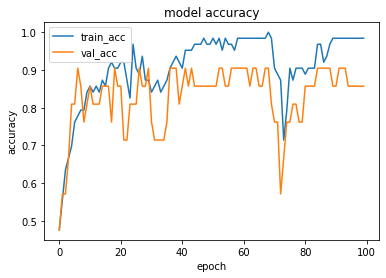

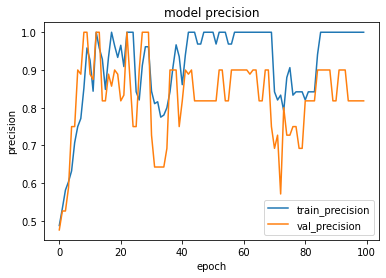

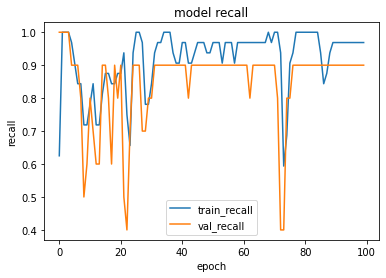

In [123]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history[f'precision_{num}'], label = "train_precision")
        plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
        plt.title('model precision')
        plt.ylabel('precision')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history[f'recall_{num}'], label = "train_recall")
        plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
        plt.title('model recall')
        plt.ylabel('recall')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history[f'precision'], label = "train_precision")
        plt.plot(history.history[f'val_precision'], label = "val_precision")
        plt.title('model precision')
        plt.ylabel('precision')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history[f'recall'], label = "train_recall")
        plt.plot(history.history[f'val_recall'], label = "val_recall")
        plt.title('model recall')
        plt.ylabel('recall')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

plot(history, num = 12)

## Our uncalibrated approach with no augmentations get 82.6% accuracy and 84.6% on precision and recall. 
# Time to do add image augmentations!

## Our model could also be struggling a bit because of: 

- not enough data (image augmentations can help) 
- too short data (meaning 100 frames isn't enough to detect) 
    - just make it second dependent 
- bad data (camera shaky / hands not seen in video) 

# First we will try solving the issue with the geometric augmentations. 

In [ ]:
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
tf.config.run_functions_eagerly(True)

In [51]:
import random 

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X 
        
class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            return tf.map_fn(_shift, X)
        else: 
            return X 

## We'll probably want to first check to see if our image augmentations make sense. 

In [ ]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("hands.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
locations = hand_locations(image) 

def draw_on_image(image, locations): 
    X_locations, Y_locations = locations[:42], locations[42:84]
    height, width, _ = image.shape

    new_image = np.zeros_like(image)
    for loc_x, loc_y in zip(X_locations, Y_locations): 
        if loc_x == 2 or loc_y == 2: continue 
        x = int(width * loc_x)
        y = int(height * loc_y)
        new_image = cv2.circle(new_image, (x, y), 5, (255, 0, 0), 10)
    plt.imshow(new_image)
    plt.show()

draw_on_image(image, locations)

In [ ]:
augger = Augmenter() 
new_locs = np.array([locations for _ in range(100)])
new_locs_aug = augger(np.array([new_locs]))[0]
new_locs_aug = np.array(new_locs_aug)

for _ in range(200): 
    new_locs_aug = _shift(new_locs)
    for locations_aug in np.array(new_locs_aug): 
        draw_on_image(image, locations_aug)
        break 

# Time to train with our augmentations for shifting in the x and y direction. 

In [138]:
# start training with a vanilla LSTM. 
import tensorflow as tf
tf.config.run_functions_eagerly(True)

model = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.LSTM(64, return_sequences = True), 
    tf.keras.layers.LSTM(128, return_sequences = False),  
    tf.keras.layers.Dense(128, activation = "relu"), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [139]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))

1s 672ms/step - loss: 0.4779 - accuracy: 0.7460 - precision_15: 0.8077 - recall_15: 0.6562 - val_loss: 0.4745 - val_accuracy: 0.9048 - val_precision_15: 0.9000 - val_recall_15: 0.9000
Epoch 17/100
2/2 [==============================] - 1s 728ms/step - loss: 0.4642 - accuracy: 0.7937 - precision_15: 0.8276 - recall_15: 0.7500 - val_loss: 0.4290 - val_accuracy: 0.8571 - val_precision_15: 0.7692 - val_recall_15: 1.0000
Epoch 18/100
2/2 [==============================] - 1s 714ms/step - loss: 0.3959 - accuracy: 0.8571 - precision_15: 0.8286 - recall_15: 0.9062 - val_loss: 0.3813 - val_accuracy: 0.8571 - val_precision_15: 0.7692 - val_recall_15: 1.0000
Epoch 19/100
2/2 [==============================] - 1s 707ms/step - loss: 0.3922 - accuracy: 0.8254 - precision_15: 0.7561 - recall_15: 0.9688 - val_loss: 0.3109 - val_accuracy: 0.8571 - val_precision_15: 0.7692 - val_recall_15: 1.0000
Epoch 20/100
2/2 [==============================] - 1s 663ms/step - loss: 0.3587 - accuracy: 0.8571 - precis

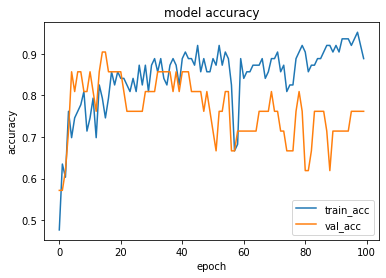

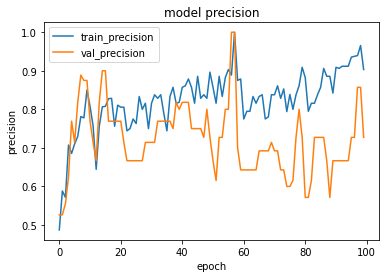

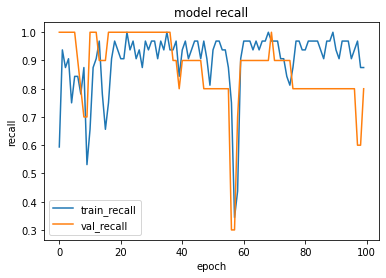

In [140]:
plot(history, num = 15)

In [54]:
model.save("85%-model-augmentations")

INFO:tensorflow:Assets written to: 85%-model-augmentations/assets
INFO:tensorflow:Assets written to: 85%-model-augmentations/assets


In [141]:
# let's see whether it can detect me not doing anything 

def predict_on_video(path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)
    
    test_frames = test_frames[:100]
    
    return model.predict(np.array([test_frames]))

In [142]:
predict_on_video("control_far.mov")

array([[0.9948758]], dtype=float32)

In [81]:
for video in os.listdir("behavior_data/control"): 
    print(predict_on_video(f"/Users/anish/Documents/Machine Learning Env/AnishMachineLearning/behavior_data/control/{video}"))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
[[0.9999877]]
[[0.99998695]]
[[0.99998784]]
[[0.9999783]]
[[0.9999877]]
[[9.248853e-06]]
[[0.9999398]]
[[0.9999875]]
[[0.00259006]]
[[0.99998784]]
[[0.99998695]]
[[0.99998784]]
[[0.9999839]]


ValueError: Input 0 of layer sequential_10 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (1, 0)

In [100]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, np.round_(model.predict(X_test)).flatten())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [104]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9 2]
 [1 9]]


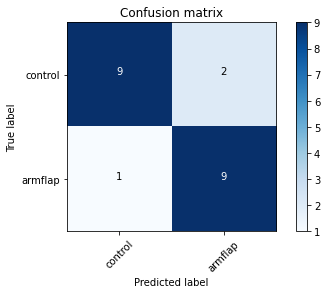

In [105]:
plot_confusion_matrix(cm, ['control', 'armflap'])

# We need to now make our data calibrated. This means we need to take a set amount of seconds from the video (number of frames depends on the video's FPS rate), instead of just take the first 100 frames (which could be 7 seconds for one video and 3 for another.) We also need to make sure that the distance between LSTM inputs is calibrated and the same regardless of FPS. 

In [3]:
# time to actually do calibration. 

SECONDS_TO_DETECT = 3 # in seconds
DISTANCE_BETWEEN_INPUTS = 0.01 # in seconds
sampling = False 

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while True: 
            _, image = cap.read() 
            if not _ : break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while len(FRAMES) < frame_rate * SECONDS_TO_DETECT: 
            _, image = cap.read() 
            if not _ : break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

control_videos: 100%|██████████| 74/74 [00:04<00:00, 16.62it/s]


In [7]:
# because all of the fps rates are different, we should figure out the average 
fps_rates = np.concatenate([ARMFLAPPING_FPS, CONTROL_FPS])
print(f"mean is {np.mean(fps_rates)}")
print(fps_rates)
for percentile in [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 0.9999]: 
    print(f"fps at the {percentile} is {np.percentile(fps_rates, percentile * 100)}")

mean is 25.48731884057971
[29.68 30.   30.   29.68 30.   14.77 30.   14.77 30.   30.   29.68 14.77
 30.   23.95 30.   29.97 30.   30.   23.95 30.   14.77 14.77 30.   23.95
 30.   23.95 14.77 30.   23.95 23.95 14.77 23.95 23.95 14.77 30.   30.
 14.77 23.95 15.   23.95 23.95 30.   23.95 30.   15.   23.95 15.   30.
 23.95 23.95 19.92 30.   30.   30.   30.   23.95 23.95 30.   30.   23.95
 29.68 14.77 29.99 14.77 29.68 29.68 29.68 29.68 29.68 29.99 29.99 29.68
 29.68 29.68 29.68 29.68 29.68 19.96 24.12 30.   29.67 30.   24.12 29.68
 29.99 30.   30.   30.   29.97 10.02 29.97 19.96 30.   30.   29.97 30.
 30.   30.   15.   15.   29.92 15.   19.92 29.97 15.   29.97 29.97 30.
 15.   23.98 15.   23.95 29.97 30.   15.   15.   29.97 29.97 23.95 15.
 30.   30.   23.95 30.   30.   24.   19.92 23.95 23.95 19.92 23.98 30.
 30.   30.   30.   29.97 10.02 29.99]
fps at the 0.1 is 15.0
fps at the 0.2 is 19.92
fps at the 0.4 is 23.980000000000004
fps at the 0.5 is 29.68
fps at the 0.6 is 29.97
fps at the 0.

In [8]:
# we'll just use 24 as the average frame rate
avg_frame_rate = 24 

if sampling: 
    import math
    ARMFLAPPING_FRAMES_NEEDED, CONTROL_FRAMES_NEEDED = [], [] 
    for i, (FRAMES, fps) in enumerate(zip(ARMFLAPPING_VIDEOS, ARMFLAPPING_FPS)):
        fps_adj = fps * DISTANCE_BETWEEN_INPUTS
        frames_needed_no_skip = SECONDS_TO_DETECT * fps 
        if frames_needed_no_skip % fps_adj == 0 : 
            ARMFLAPPING_FRAMES_NEEDED.append(frames_needed_no_skip / fps_adj)
        else: 
            avg_fps_adj = avg_frame_rate * DISTANCE_BETWEEN_INPUTS 
            frames_needed_no_skip = SECONDS_TO_DETECT * fps 
            frames_needed = int(frames_needed_no_skip * avg_fps_adj / fps_adj)
            if len(FRAMES) < frames_needed: 
                frames_needed = len(FRAMES)
            ARMFLAPPING_FRAMES_NEEDED.append(frames_needed)

    for i, (FRAMES, fps) in enumerate(zip(CONTROL_VIDEOS, CONTROL_FPS)):
        fps_adj = fps * DISTANCE_BETWEEN_INPUTS
        frames_needed_no_skip = SECONDS_TO_DETECT * fps 
        if frames_needed_no_skip % fps_adj == 0 : 
            CONTROL_FRAMES_NEEDED.append(frames_needed_no_skip / fps_adj)
        else: 
            avg_fps_adj = avg_frame_rate * DISTANCE_BETWEEN_INPUTS 
            frames_needed_no_skip = SECONDS_TO_DETECT * fps 
            frames_needed = int(frames_needed_no_skip * avg_fps_adj / fps_adj)
            if len(FRAMES) < frames_needed: 
                frames_needed = len(FRAMES)
            CONTROL_FRAMES_NEEDED.append(frames_needed)

    # the next step is to get all of those frames and pad as necessary 
    ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []

    for FRAMES, frames_needed in zip(ARMFLAPPING_VIDEOS, ARMFLAPPING_FRAMES_NEEDED): 
        vid = FRAMES[:int(frames_needed)]
        locs = []
        for frame in vid: 
            locs.append(hand_locations(frame))
        ARMFLAPPING_LOCATIONS.append(locs)

    for FRAMES, frames_needed in zip(CONTROL_VIDEOS, CONTROL_FRAMES_NEEDED): 
        vid = FRAMES[:int(frames_needed)]
        locs = []
        for frame in vid: 
            locs.append(hand_locations(frame))
        CONTROL_LOCATIONS.append(locs)

In [5]:
if not sampling: 
    # then just get the locations 
    ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
    for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
        locs = []
        for frame in FRAMES: 
            locs.append(hand_locations(frame))
        ARMFLAPPING_LOCATIONS.append(locs)
    
    for FRAMES in tqdm(CONTROL_VIDEOS):  
        locs = []
        for frame in FRAMES: 
            locs.append(hand_locations(frame))
        CONTROL_LOCATIONS.append(locs)

100%|██████████| 61/61 [02:01<00:00,  1.99s/it]


In [6]:
print([len(_) for _ in CONTROL_LOCATIONS])
print([len(_) for _ in ARMFLAPPING_LOCATIONS])

[60, 73, 90, 90, 90, 73, 90, 90, 90, 90, 90, 90, 31, 90, 60, 90, 90, 90, 90, 90, 90, 45, 45, 90, 45, 60, 90, 45, 90, 90, 90, 45, 72, 45, 72, 90, 90, 45, 45, 90, 90, 72, 45, 90, 90, 72, 90, 90, 72, 60, 72, 72, 60, 72, 90, 90, 90, 90, 90, 31, 90]
[179, 180, 210, 208, 150, 104, 210, 89, 150, 150, 179, 60, 180, 120, 180, 120, 120, 180, 120, 210, 60, 45, 210, 120, 180, 96, 89, 180, 72, 96, 89, 96, 120, 60, 210, 210, 45, 168, 60, 144, 168, 150, 120, 120, 90, 96, 75, 120, 120, 120, 80, 210, 120, 210, 180, 120, 120, 210, 180, 144, 179, 104, 120, 104, 179, 179, 208, 179, 179, 120, 150, 179, 179, 179, 179, 179, 179]


In [9]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

61it [00:00, 13751.08it/s]
61it [00:00, 7024.48it/s](61, 90, 126) (61, 90, 126)



In [12]:
X_train, X_test, y_train, y_test = generate_data(padded_armflapping_locations, padded_control_locations)

In [27]:
# start training with a vanilla LSTM. 
import tensorflow as tf
tf.config.run_functions_eagerly(True)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences = True), 
    tf.keras.layers.LSTM(128, return_sequences = True), 
    tf.keras.layers.LSTM(256, return_sequences = False), 
    tf.keras.layers.Dense(128, activation = "relu"), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [28]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))

val_precision_6: 0.6842 - val_recall_6: 0.7222
Epoch 15/100
3/3 [==============================] - 2s 575ms/step - loss: 0.5931 - accuracy: 0.6593 - precision_6: 0.6500 - recall_6: 0.6047 - val_loss: 0.6015 - val_accuracy: 0.7419 - val_precision_6: 0.7778 - val_recall_6: 0.7778
Epoch 16/100
3/3 [==============================] - 2s 651ms/step - loss: 0.5913 - accuracy: 0.7253 - precision_6: 0.7045 - recall_6: 0.7209 - val_loss: 0.6080 - val_accuracy: 0.6774 - val_precision_6: 0.7000 - val_recall_6: 0.7778
Epoch 17/100
3/3 [==============================] - 2s 659ms/step - loss: 0.5573 - accuracy: 0.7363 - precision_6: 0.6863 - recall_6: 0.8140 - val_loss: 0.5845 - val_accuracy: 0.7419 - val_precision_6: 0.8125 - val_recall_6: 0.7222
Epoch 18/100
3/3 [==============================] - 2s 584ms/step - loss: 0.5517 - accuracy: 0.7143 - precision_6: 0.7179 - recall_6: 0.6512 - val_loss: 0.6126 - val_accuracy: 0.7097 - val_precision_6: 0.8000 - val_recall_6: 0.6667
Epoch 19/100
3/3 [=======

In [29]:
plot(history, num=6) # are the graphs also similar this time? 

NameError: name 'plot' is not defined

# Very differing behavior in training, probably due to limited data. I'll have to see what to do about that and how to squeeze even more data. 

In [ ]:
# we'll manually do some prepreprocessing 
